In [1]:
from Time2State.time2state import Time2State
from Time2State.adapers import CausalConv_LSE_Adaper
from Time2State.clustering import DPGMM
from Time2State.default_params import *
import pandas as pd
from sklearn.preprocessing import StandardScaler
from TSpy.view import plot_mts
import matplotlib.pyplot as plt
import numpy as np
from utils import *


Cuda is available.


In [2]:
win_size = 8000
step = 5000

# Load data
data = np.loadtxt("./data/EEG.csv", delimiter=",")#pd.read_csv('data/MoCap/4d/amc_86_02.4d', sep=' ').to_numpy()
#data = StandardScaler().fit_transform(data)
data = data.T

In [3]:
labels = np.loadtxt("./data/EEG_labels.csv", delimiter=",")
ground_truth = np.where(labels[:-1] != labels[1:])[0]

In [4]:
data.shape

(259520, 64)

In [5]:
# model
params_LSE['in_channels'] = data.shape[1]
params_LSE['out_channels'] = 64
params_LSE['nb_steps'] = 30
params_LSE['win_size'] = win_size
params_LSE['win_type'] = 'hanning' # {rect, hanning}

In [7]:
import time

In [10]:
start = time.time()
t2s = Time2State(win_size, step, CausalConv_LSE_Adaper(params_LSE), DPGMM(None), params_LSE)
t2s.fit(data, win_size, step)
end = time.time()
print(end-start)
predictions =  np.where(t2s.state_seq[:-1] != t2s.state_seq[1:])[0]
print('covering score:',covering(ground_truth, predictions, len(labels)))
margin = 4200
print('margin:',margin)
print('f_measure score:',f_measure(ground_truth, predictions, margin=margin, alpha=0.5, return_PR=True))

284.3331038951874
covering score: 0.4542233388262689
margin: 4200
f_measure score: (0.45901639344262296, 0.2978723404255319, 1.0)


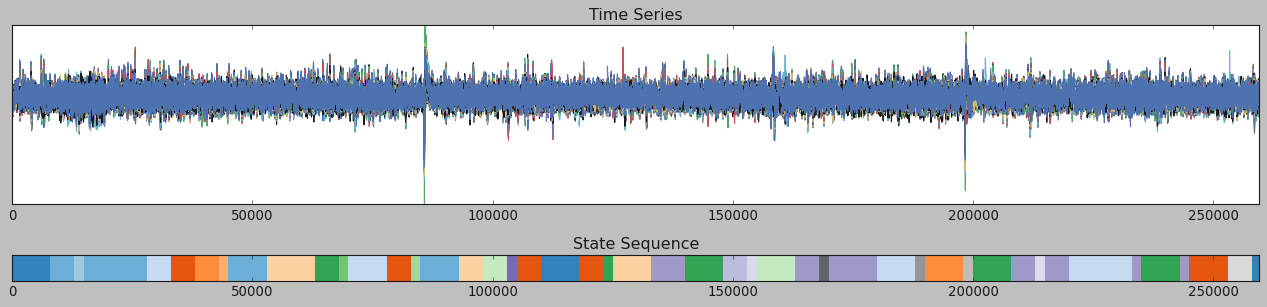

In [25]:
plt.style.use('classic')
plot_mts(data, t2s.state_seq)
plt.savefig('demo.png')

In [33]:
t2s.state_seq

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
def _true_positives(T, X, margin=5):
    '''
    Compute true positives without double counting
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _true_positives({1, 10, 20, 23}, {3, 8, 20})
    {1, 10, 20}
    >>> _true_positives({1, 10, 20, 23}, {1, 3, 8, 20})
    {1, 10, 20}
    >>> _true_positives({1, 10, 20, 23}, {1, 3, 5, 8, 20})
    {1, 10, 20}
    >>> _true_positives(set(), {1, 2, 3})
    set()
    >>> _true_positives({1, 2, 3}, set())
    set()
    '''
    # make a copy so we don't affect the caller
    X = set(list(X))
    TP = set()
    for tau in T:
        close = [(abs(tau - x), x) for x in X if abs(tau - x) <= margin]
        close.sort()
        if not close:
            continue
        dist, xstar = close[0]
        TP.add(tau)
        X.remove(xstar)
    return TP


def f_measure(ground_truth, predictions, margin=5, alpha=0.5, return_PR=False):
    '''
    Compute the F-measure based on human annotations. Remember that all CP locations are 0-based!
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Parameters
    -----------
    :param annotations: dict from user_id to iterable of CP locations
    :param predictions: iterable of predicted CP locations
    :param alpha: value for the F-measure, alpha=0.5 gives the F1-measure
    :return: whether to return precision and recall too
    Examples
    -----------
    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    '''
    annotations =	{'1':ground_truth}
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(_true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: _true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F


def _overlap(A, B):
    '''
    Return the overlap (i.e. Jaccard index) of two sets
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _overlap({1, 2, 3}, set())
    0.0
    >>> _overlap({1, 2, 3}, {2, 5})
    0.25
    >>> _overlap(set(), {1, 2, 3})
    0.0
    >>> _overlap({1, 2, 3}, {1, 2, 3})
    1.0
    '''
    return len(A.intersection(B)) / len(A.union(B))


def _partition_from_cps(locations, n_obs):
    '''
    Return a list of sets that give a partition of the set [0, T-1], as
    defined by the change point locations.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _partition_from_cps([], 5)
    [{0, 1, 2, 3, 4}]
    >>> _partition_from_cps([3, 5], 8)
    [{0, 1, 2}, {3, 4}, {5, 6, 7}]
    >>> _partition_from_cps([1,2,7], 8)
    [{0}, {1}, {2, 3, 4, 5, 6}, {7}]
    >>> _partition_from_cps([0, 4], 6)
    [{0, 1, 2, 3}, {4, 5}]
    '''
    T = n_obs
    partition = []
    current = set()

    all_cps = iter(sorted(set(locations)))
    cp = next(all_cps, None)
    for i in range(T):
        if i == cp:
            if current:
                partition.append(current)
            current = set()
            cp = next(all_cps, None)
        current.add(i)
    partition.append(current)
    return partition


def _cover_single(Sprime, S):
    '''
    Compute the covering of a segmentation S by a segmentation Sprime.
    This follows equation (8) in Arbaleaz, 2010.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _cover_single([{1, 2, 3}, {4, 5}, {6}], [{1, 2, 3}, {4, 5, 6}])
    0.8333333333333334
    >>> _cover_single([{1, 2, 3, 4}, {5, 6}], [{1, 2, 3, 4, 5, 6}])
    0.6666666666666666
    >>> _cover_single([{1, 2}, {3, 4}, {5, 6}], [{1, 2, 3}, {4, 5, 6}])
    0.6666666666666666
    >>> _cover_single([{1, 2, 3, 4, 5, 6}], [{1}, {2}, {3}, {4, 5, 6}])
    0.3333333333333333
    '''
    T = sum(map(len, Sprime))
    assert T == sum(map(len, S))
    C = 0
    for R in S:
        C += len(R) * max(_overlap(R, Rprime) for Rprime in Sprime)
    C /= T
    return C


def covering(ground_truth, predictions, n_obs):
    '''
    Compute the average segmentation covering against the human annotations.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Parameters
    -----------
    @param annotations: dict from user_id to iterable of CP locations
    @param predictions: iterable of predicted Cp locations
    @param n_obs: number of observations in the series
    Examples
    -----------
    >>> covering({1: [10, 20], 2: [10], 3: [0, 5]}, [10, 20], 45)
    0.7962962962962963
    >>> covering({1: [], 2: [10], 3: [40]}, [10], 45)
    0.7954144620811286
    >>> covering({1: [], 2: [10], 3: [40]}, [], 45)
    0.8189300411522634
    '''
    annotations =	{'1':ground_truth}
    Ak = {
        k + 1: _partition_from_cps(annotations[uid], n_obs)
        for k, uid in enumerate(annotations)
    }
    pX = _partition_from_cps(predictions, n_obs)

    Cs = [_cover_single(pX, Ak[k]) for k in Ak]
    return sum(Cs) / len(Cs)


In [48]:
len(t2s.state_seq)

376417

In [42]:
ground_truth

array([  2927,  30114,  53594,  75311,  84966, 108539, 118759, 141700,
       154280, 162400, 173395, 180875, 184561, 192331, 199750, 223758,
       246011, 253174, 273439, 283095, 306670, 312741, 334006, 348887,
       361799], dtype=int64)

covering score: 0.4335605773729705
margin: 3000
f_measure score: (0.19923371647509577, 0.11063829787234042, 1.0)
